<mark> <font size="3"> Suman Pan - 218352 </mark>


<mark> <font size="3"> Clara Llòria - 218147 </mark>

# Lab 5: Stereo Matching and Shape from Silhouette

This lab session is divided in two parts. In the first one, you will compute a disparity map from a pair of images.  A disparity map is an image that stores the inverse of the distance to the camera center of the points
seen at every pixel, i.e. the depth.  This will enable us, for example in case our cameras are calibrated, to display a dense cloud of points representing the scene.

To compute the disparity map with a local method, we will have to compute correspondences for every pixel in the reference image.  These are many more correspondences than the ones given by SIFT/SURF/ORB.  For every pixel in the first image, we will travel its corresponding epipolar line in the second image looking for its correspondence. Since the pair of images are stereo-rectified (parallel views) the epipolar lines are horizontal and the coordinates of the corresponding points differ just by a horizontal displacement, the disparity.  By comparing the information around a neighborhood of the pixels on both images we will decide whether the pixels do correspond to each other.

In the second part, you will compute a 3D reconstruction of an object given some binary images corresponding to different points of view. These binary images, called the silhouettes, contain a segmentation of the object of interest that we want to reconstruct.

In particular, the goal of this lab session is to learn the following concepts:

- How to compute disparity/depth maps from pairs of images.
- Compare different cost functions and window sizes.
- How to aggregate costs through bilateral weights.
- How to extract a Visual Hull from a set of different views.

In [1]:
import math
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt

## 1. Stereo matching

First we will work with a pair of stereo-recified images from the Middlebury stereo dataset: http://vision.middlebury.edu/stereo/. The ground truth disparity is available and it will be useful to validate the code to be completed and it will allow us to measure errors as well.

The incomple function `stereo_computation` is provided; you have to complete it with the SSD cost, the NCC similarity measure and the bilateral weights. 

**Q1.** Complete the `stereo_computation` function with the computation of the SSD cost.

**Q2.** Execute cell code given after the `stereo_computation` function. This code estimates the disparity between a pair of stereo rectified images. How do the error in the estimation and the occluded areas are related?

**Q3.** Compute the global error.

**Q4.** Evaluate the results changing the window size (e.g. 5$\times$5, 9$\times$9, 21$\times$21). Comment the results and the differences among the different results.

**Q5.** Complete the `stereo_computation` function with the computation of the NCC cost.

**Q6.** Compare the results with those obtained with the SDD cost.

**Q7.** Complete the `stereo_computation` function with the bilateral weights. Suggested parameters: $\gamma_{col}=12$ and `math.floor(win_size/2)` for $\gamma_{pos}$.

**Q8.** Evaluate the results changing the window size (e.g. 5 $\times$ 5, 9 $\times$ 9, 21 $\times$ 21) and compare to the previous case that uses uniform weights (SDD cost).


In [8]:
# bilateral weights
def get_bilateral_weights( win_img, win_size):
    
    gamma_col,gamma_pos = 12, math.floor(win_size/2)
    
    h, w, channels = np.shape(win_img)
    weights=np.zeros([h,w,channels])
    # p is the central pixel of the window, so it remains constant while q will be iterated
    p = math.floor(h/2),math.floor(w/2)
    # iterate the window
    for i in range(h):
        for j in range(w):
            q = i,j

            delta_c=(1/3)*(np.abs( win_img[p]- win_img[q] )).sum()
            delta_g= np.sqrt((p[0]-q[0])**2+(p[1]-q[1])**2)

            w_col =- delta_c/gamma_col
            w_pos =- delta_g/gamma_pos

            weights[i,j] = np.exp(-(w_col+w_pos))

    return weights


In [9]:
def stereo_computation(color_left_img, color_right_img, min_disparity, max_disparity, win_size, bilateral_weights=False, method='ssd'):
    """
    -left image
    -right image
    -minimum disparity
    -maximum disparity
    -window size
    -bilateral_weights
    -matching cost
    """
    
    # conversion to float images to make calculations
    color_left_img = color_left_img.astype(np.float32)
    color_right_img = color_right_img.astype(np.float32)
    height, width, channel = np.shape(color_left_img)
    
    # win_step corresponds to half the window size
    win_step = int(win_size/2)

    disparity = np.zeros([height,width])
    err_cost=np.zeros(max_disparity)
    disp_map = np.zeros(max_disparity)

    # start weights to 0
    w = 1 
    
    # iterate over the image
    for i in range(win_step, height-win_step):
        for j in range(win_step, width-win_step):

            # take the first window that will remain constant in the left image            
            win_1 = color_left_img[i-win_step:i+win_step+1, j-win_step:j+win_step+1]
            
            # for each pixel in the image, find the weight
            if bilateral_weights:
                p_interest = i,j
                w = get_bilateral_weights(win_1, win_size)
                
            # move the window in the right image with disparity going from -max_disparity to max_disparity
            # even though, some pixels it is not possible to do without getting out of the image 
            # so we need to handle which is the maximum we can iterate in both sides
            min_d = -min(max_disparity,j-win_step)
            max_d = min(width-j-win_step, max_disparity)
            
            # move the window in the right image
            for d in range(min_d,max_d):
                win_2 = color_right_img[i-win_step:i+win_step+1, j-win_step+d:j+win_step+d+1]
                
                # apply methods
                if method=='ssd':
                    err_cost[d] = (w * (win_1 - win_2)**2).sum()

                elif method=='ncc': 
                    n_total = win_size
                    win1_bar = (w * win_1).sum()
                    win2_bar = (w * win_2).sum()
                    fact_1 = (win_1 - win1_bar)
                    fact_2 = (win_2 - win2_bar)
                    numerator = (w * fact_1 * fact_2).sum()
                    sigma_I1 =  (w * (fact_1**2) ).sum()/n_total 
                    sigma_I2 =  (w * (fact_2**2) ).sum()/n_total 
                    err_cost[d] = - numerator / np.sqrt((sigma_I1 * sigma_I2))

                else:
                    raise(NameError)
                
            min_index = np.argmin(err_cost)
            min_err = np.min(err_cost)
            
            disparity[i,j]= min_index

                
  
    return disparity


In [11]:
def plot_stereo_function(img1,img2,bilateral_weights=False,method='ssd',min_disparity=0,max_disparity=16):    
    # Set window (patch) size
    w_size = [9, 5 ,21]
    ssd_disp = np.zeros(shape=(img1.shape[0], img1.shape[1]))

    for w in range(len(w_size)):
        w_size_current = w_size[w]
        ssd_disp = stereo_computation(img1, img2, min_disparity, max_disparity,
                                      w_size_current, bilateral_weights, method)

        #Display the error image with respect to the ground truth\n
        plt.imshow(ssd_disp,'gray')
        plt.xticks([]),plt.yticks([])
        plt.title("Estimation with window size: "+str(w_size_current))
        plt.show() 

# Disparity ground truth image 
def plot_GT():
    img_gt = cv2.imread('./data1/truedisp.row3.col3.pgm', cv2.IMREAD_GRAYSCALE) 
    plt.imshow(img_gt,'gray') 
    plt.xticks([]),plt.yticks([]) 
    plt.title("Ground Truth") 
    plt.show()

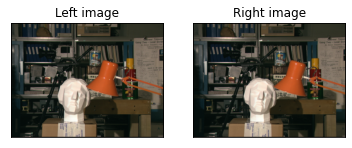

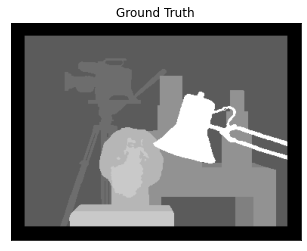

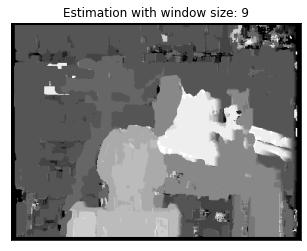

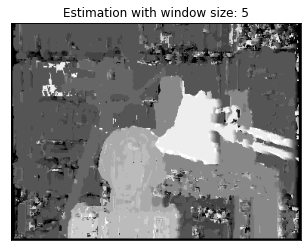

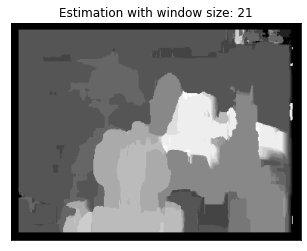

In [24]:
# Data images (rectified images)
img1 = cv2.imread('./data1/scene1.row3.col3.ppm') 
img2 = cv2.imread('./data1/scene1.row3.col2.ppm') 
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB) 
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB) 
 
plt.subplot(1,2,1),plt.imshow(img1) 
plt.title('Left image') 
plt.xticks([]),plt.yticks([]) 
plt.subplot(1,2,2),plt.imshow(img2) 
plt.title('Right image') 
plt.xticks([]),plt.yticks([]) 
plt.show() 
     
plot_GT()
plot_stereo_function(img1,img2,False,'ssd')

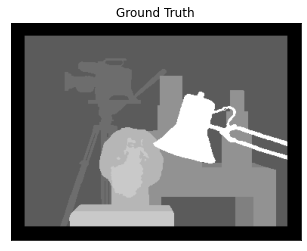

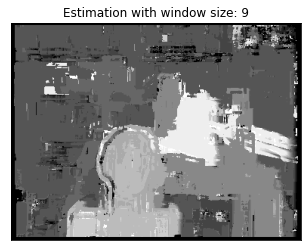

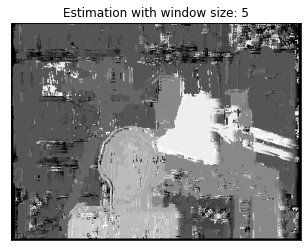

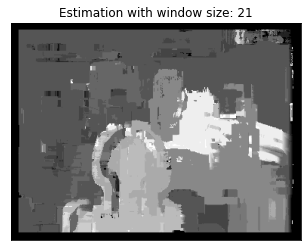

In [26]:
plot_GT()
plot_stereo_function(img1,img2,True,'ssd')

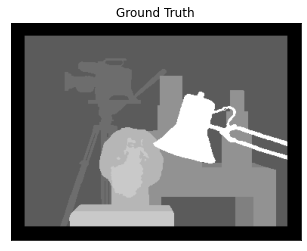

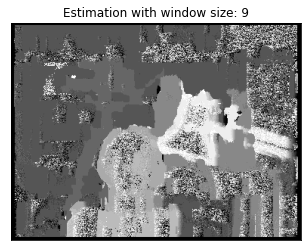

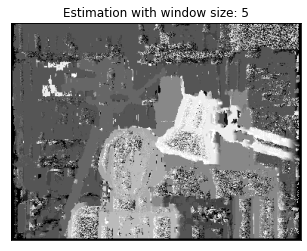

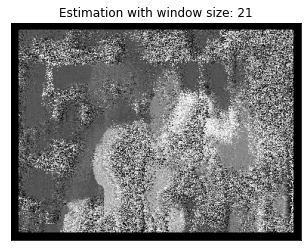

In [26]:
plot_GT()
plot_stereo_function(img1,img2,False,'ncc')

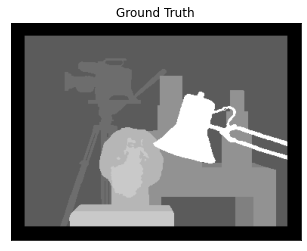

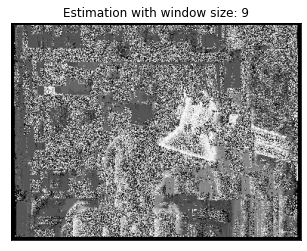

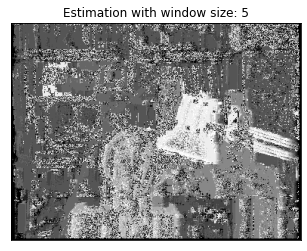

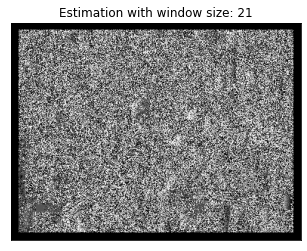

In [25]:
plot_GT()
plot_stereo_function(img1,img2,True,'ncc')

<mark>**ANSWERS:**</mark>

**- Q2: How do the error in the estimation and the occluded areas are related?**

If we cannot find the apropiate correspondence because the pixel is occluded, we may take a wrong disparity value, therefore there will be a error in the estimation of the stereo computation. This can happen both because the algorithm is not able to find a correspondence for a given pixel because it is occluded in one of the images, or because it finds a wrong match corresponding to another part of the image. In both cases the result will have an error caused by a mistake in the obtained disparity.

**- Q4: Evaluetate the results changing the window size (e.g. 5 × 5, 9 × 9, 21 × 21). Comment the results and the differences among the different results.**

We notice that the of the window size is related with results of depth computation, since we can get better or worse results by changing it. Using a smaller window, we found that there is more detail in the boundaries (case of 5x5) but the result has more noise. However, with a large window (case of 21x21), we found less detail but smoother results of disparity maps (fatterning effect)[1]. Finally, in the case of 9x9 we have a middle effect with respect to before ones.

This effect is due the search of the pixel correspondence in the target image: when we increase the patch size of the image, we are assuming more that all the pixels in the corresponding patch have similar depth, ie. similar disparities.


**- Q6: Compare the results with those obtained with the SDD cost and NCC cost**

We suppose that results obtained with NCC cost may be smoother than using SDD method, since using Normalized Cross Correlation we are normalaizing the errors. Even though, we may have some error in our code, since the result is not improving as we would expect but we obtain a lot of noise.

On the other hand, in paper [2], specifically in equation 11, we found that we need to normalize some factor with N, to compute the NCC.

**- Q8: Evaluate the results changing the window size (e.g. 5  ×  5, 9  ×  9, 21  ×  21) and compare to the previous case that uses uniform weights (SDD cost).**

As explained before using uniform weights in some cases using large window size, we could have some artifacts called foregound-fattening or fatterning effect since the depth assigned is wrong in the near discontinuities. This artifiact could be improved with the support of bilateral weights of the pixels, which combine similarity and geometric proximity to the center of our pixel of interest. Therefore, we expect that using bilateral weights reduces the fattening effect in near depth discontinuities. For this reason, pixels belonging to the same object should have approximately the same depth, and therefore the weights for pixels in the same group will be higher. [1]

Comparing the results with respect to the previous case, using bilateral weights with larger window size (21x21) we can still mantain the details with less noise in the final result. In the other cases, we found this similar effect, so we improve the noise and details in the depth result.

According to paper [1], the error decreases when $\gamma_{col}$ increases and it stabilizes after $\gamma_{col}= 20$. On the other hand, the influence of $\gamma_{grad}$ is greater and its optimal value is $\gamma_{grad} = 2$.
So, in our case using $\gamma_{col}= 12$, we can find some error in the result image.

Reference:

[1]Laura Fernández Julià, and Pascal Monasse, Bilaterally Weighted Patches for Disparity Map Computation, Image Processing On Line, 5 (2015), pp. 73–89. https://doi.org/10.5201/ipol.2015.123


[2]Heo, Yong & Lee, Kyoung Mu & Lee, Sang. (2011). Robust Stereo Matching Using Adaptive Normalized Cross-Correlation. Pattern Analysis and Machine Intelligence, IEEE Transactions on. 33. 807 - 822. 10.1109/TPAMI.2010.136. 

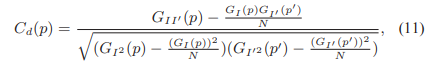

Once the code is completed and you finish the experiments with the Middlebury image, the next step is to apply the code to our lab 4 images. These images are not rectified, we have rectified them by applying a proper homography to each one of them. The stereo-rectified images are the ones provided in this lab. The lab images are big. To speed up the computations, you can scale-down the images by a factor of 0.25. Once everything is working properly, you can increase the scale in order to get higher resolution results.

**Q9.** Set proper values for the disparity limits.

**Q10.** Comment the result obtained. Why do you think the disparity is not well estimated
in some parts of the image?

<mark>**ANSWER:**</mark>

To use this method we need to apply stereo rectification to the input images. The reason is because this algorithm tries to compute the pixel correspondence, so if the pixels are wrongly assigned the disparity will also be wrong. Therefore in those parts of the image the disparity is not correctly estimated, and this error is also caused when there are self-similarity areas or occlusions in the input image.

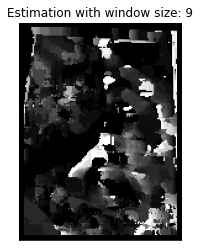

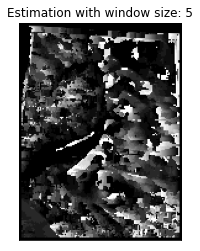

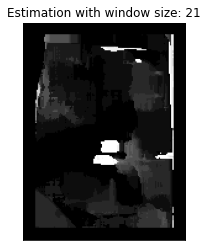

In [22]:
img1 = cv2.imread('./data1/rectif0.png')
img2 = cv2.imread('./data1/rectif1.png')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

scale_percent = 15 # percent of original size
width = int(img1.shape[1] * scale_percent / 100)
height = int(img1.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
img1 = cv2.resize(img1, dim)
img2 = cv2.resize(img2, dim)

plot_stereo_function(img1,img2,min_disparity=0,max_disparity=20)


## 2. Shape from silhouette: visual hull method

The Visual Hull is a 3D reconstruction technique that allows to recover a 3D shape given its silhouettes in different views. A silhouette is a mask that provides a segmentation of the foreground object. The Visual Hull may be obtained as the intersection of the visual cones of the different points of view, which are generated by backprojection of the silhouttes using camera parameters. The advantage of this method is that it is very simple, it is non-iterative and can be easily parallelized. Its main disadvantage is the inability to obtain the exact shape of the object (e.g. cavities in the object cannot be recovered) but it is widely used with multi-view stereo algorithms, either as a first step or in conjunction with the multi-view reconstruction providing additional constraints.
In practice, the visual cones are not estimated, instead, a voxel grid is defined and all the voxels of the grid are projected onto each image ir order to check if the voxel projects inside the object silhouette or not.

In order to visualize the 3D volume we will use the Python library IPyvolume: https://ipyvolume.readthedocs.io/en/latest/ 

You will have to install the library, more information here: https://ipyvolume.readthedocs.io/en/latest/install.html

In our case it worked with the following commands:

- `pip install ipyvolume`
 
- `jupyter nbextension enable --py --sys-prefix ipyvolume` 
 
- `jupyter nbextension enable --py --sys-prefix widgetsnbextension`

In [2]:
# !pip install ipyvolume

# !jupyter nbextension enable --py --sys-prefix ipyvolume

# !jupyter nbextension enable --py --sys-prefix widgetsnbextension

Enabling notebook extension ipyvolume/extension...
      - Validating: ok
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


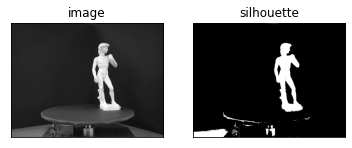

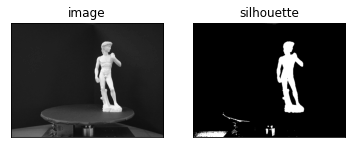

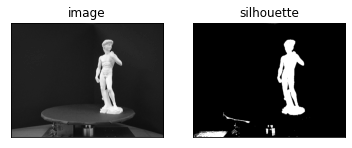

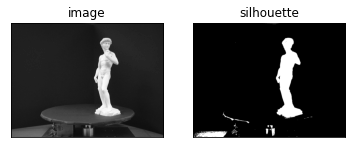

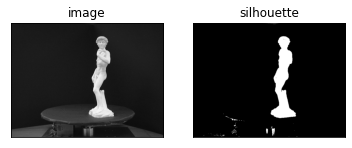

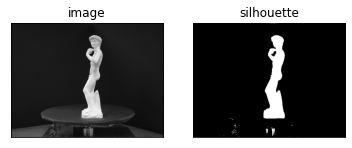

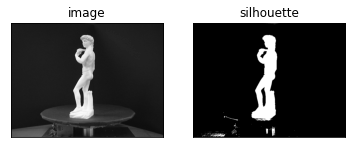

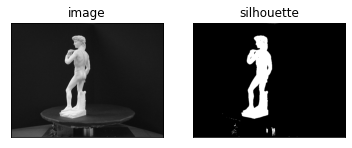

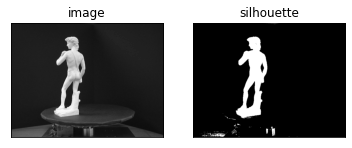

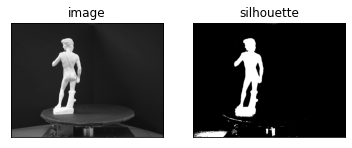

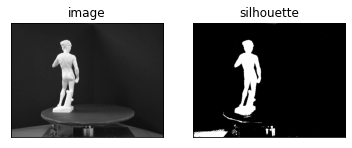

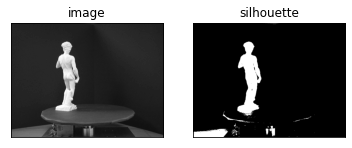

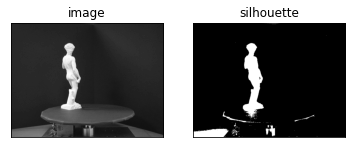

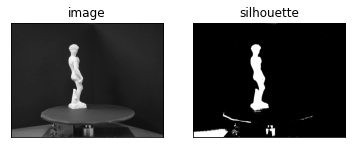

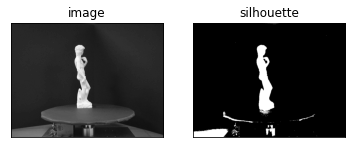

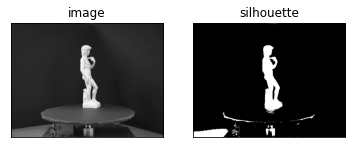

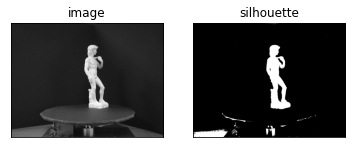

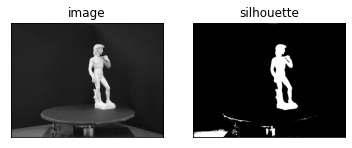

In [4]:
import ipyvolume as ipv

# Shape from silhouette - Visual Hull algorithm

# Define variables
bbox = np.array([[0.2, -0.3, -1.8],[2.2, 1.3, 2.7]]) # [minX minY minZ; maxX maxY maxZ]
volumeX = 40 # 64 # start with a small volume and once code works properly you can increase its size
volumeY = 40 # 64
volumeZ = 80 # 128
volumeThreshold = 17
silhouetteThreshold = 100
numCameras = 18

# Load silhouette images and projection matrices
images = []
Ps = []
for i in range(numCameras):
    
    P = np.loadtxt("data2/david_{:02d}.pa".format(i), delimiter=' ')
    Ps.append(P)
    
    m = cv2.imread("data2/david_{:02d}.jpg".format(i),cv2.IMREAD_GRAYSCALE)
    ret,sil = cv2.threshold(m,silhouetteThreshold,255,cv2.THRESH_BINARY)
    images.append(sil)
    
    plt.subplot(1,2,1),plt.imshow(m,'gray',vmin=0,vmax=255)
    plt.title('image')
    plt.xticks([]),plt.yticks([])
    plt.subplot(1,2,2),plt.imshow(sil,'gray',vmin=0,vmax=255)
    plt.title('silhouette')
    plt.xticks([]),plt.yticks([])
    plt.show()

T = np.identity(4)
T[:3,3] = bbox[0,:]
T = T @ np.diag([(bbox[1,0]-bbox[0,0])/volumeX, (bbox[1,1]-bbox[0,1])/volumeY, (bbox[1,2]-bbox[0,2])/volumeZ, 1])

F = np.array([[1, 0, 0, 0],[0, 0, 1, 0],[0, -1, 0, 0],[0, 0, 0, 1]]) # flip y and z axes for better display in isosurface
T = F @ T

Execute the code in the cell above.

**Q11.** How are the silhouettes extracted in the provided code? Would it work in a general case? Why?

Execute the following cell code.

<mark>**ANSWER**</mark>

We have been provided with two kinds of files for each camera view: one with the image itself and another one with the matrix P containing the parameters of the calibrated camera. Therefore, to extract the silhouettes we need to read those images and do a segmentation based on a defined threshold, so that the pixels of the image having a value greater than this threshold will have a final value of 1, and the rest will be 0. In this way we can easily know which parts are containing the object and which are not.
    
This is working well in this case because there is a clear difference between the object and de background, since the first one is mostly white and the second one is almost black. Even though, in the cases where the difference is not that clear because the foreground has some parts below the threshold or the other way around, the segmentation may not be quite well and this would not be the best method to use in that case.

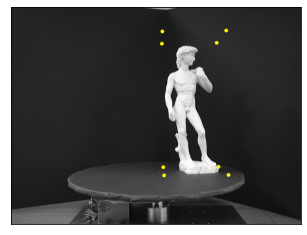

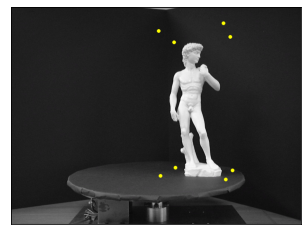

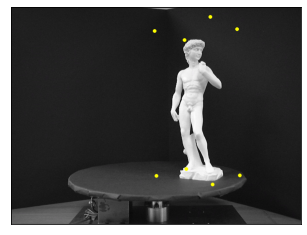

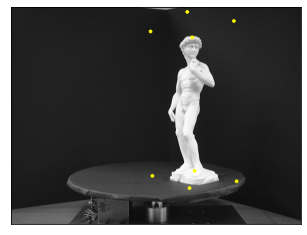

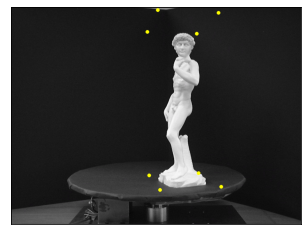

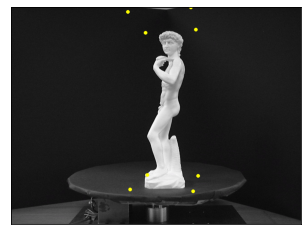

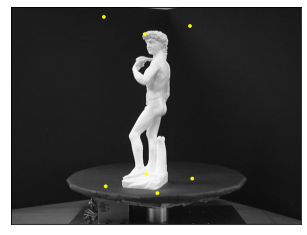

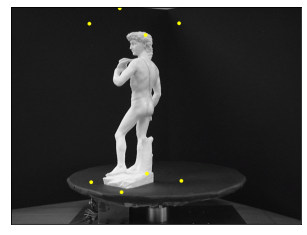

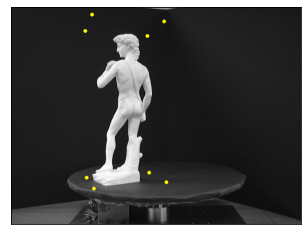

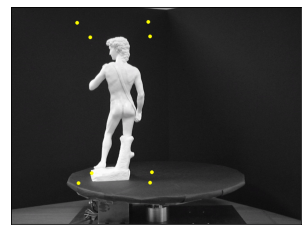

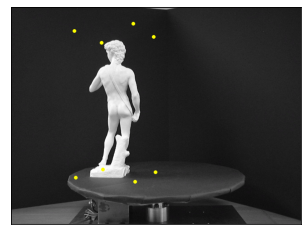

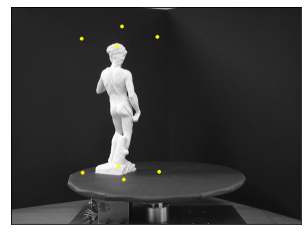

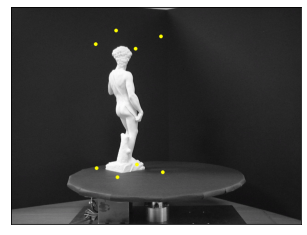

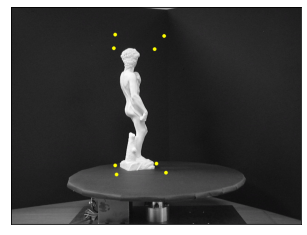

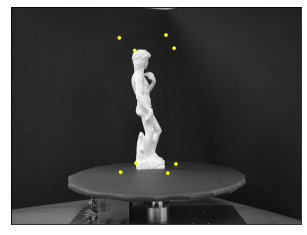

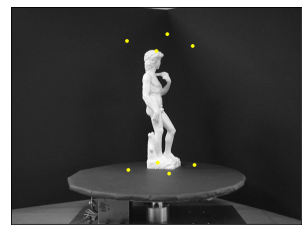

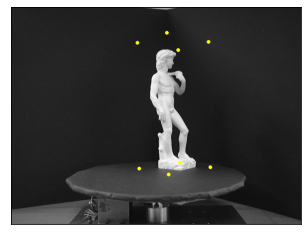

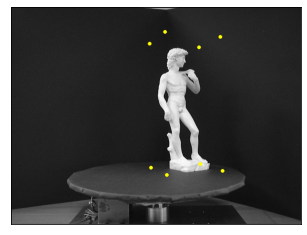

In [5]:
from PIL import Image, ImageDraw

# Draw projection of volume corners
for i in range(numCameras):

    corners = np.array([[0, 0, 0, 1],[0, 0, volumeZ, 1],[0, volumeY, 0, 1], [0, volumeY, volumeZ, 1], [volumeX, 0, 0, 1], [volumeX, 0, volumeZ, 1], [volumeX, volumeY, 0, 1], [volumeX, volumeY, volumeZ, 1]])
    corners = corners.T
    pcorners = Ps[i] @ T @ corners
    pcorners = pcorners / pcorners[2][np.newaxis]
    
    img_path = "data2/david_{:02d}.jpg".format(i)
    I = Image.open(img_path)
    plt.figure()
    canv2 = ImageDraw.Draw(I)
    for i in range(8):
        canv2.ellipse((pcorners[0,i], pcorners[1,i], pcorners[0,i]+7, pcorners[1,i]+7), fill = 'yellow', outline ='yellow')
    plt.xticks([]),plt.yticks([])
    plt.imshow(I)


**Q12.** In your opinion, what is the projection of volume corners useful for.

<marker>**ANSWER**</marker>

Projecting the corners to the image is useful in order to know how the volume that we need to iterate is located in each image.

The following cell contains the visual hull algorithm with a missing part that needs to be completed.

**Q13.** Complete the missing part of the code and execute the final cell to visualize the 3D reconstruction.

In [20]:
# Visual Hull computation

volume = np.zeros((volumeX,volumeY,volumeZ))

x = np.arange(0.5, volumeX, 1)
y = np.arange(0.5, volumeY, 1)
z = np.arange(0.5, volumeZ, 1)
voxel3Dx, voxel3Dy, voxel3Dz = np.meshgrid(x, y, z)
ny, nx = images[0].shape
    
# iterate the voxels in the volume for each image
for n in range(numCameras):
    for x in range(volumeX):
        for y in range(volumeY):
            for z in range(volumeZ):
                voxel = np.array([voxel3Dx[x,y,z], voxel3Dy[x,y,z], voxel3Dz[x,y,z], 1])
                world_coords = T @ voxel.T
                # project the world coordinates of the voxel to the image plane of the camera to get pixel coordinates
                image_pixel = np.dot(Ps[n], world_coords)
                # normalize
                image_pixel /= image_pixel[2]

                # get current image
                curr_image = images[n]
                # read the value of the segmented image corresponding to the picel coordinates found previously
                x_img=int(image_pixel[0])-1
                y_img = int(image_pixel[1]) - 1
                
                # handle out of image cases
                if y_img <= nx or x_img <= ny:
                    value = curr_image[y_img ,x_img]
                    # if value in the image is white, then this voxel is occupied
                    if value == 255:
                        volume[x,y,z] += 1 

In [21]:
ipv.figure()
ipv.plot_isosurface(volume, level=volumeThreshold, color='gray', extent=[[0.2, 2.2], [-0.3, 1.3], [-1.8, 2.7]])
ipv.squarelim()
ipv.show()

C:\Users\clara\anaconda3\lib\site-packages\ipyvolume\pylab.py:593: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  values = measure.marching_cubes_lewiner(data, level)
